In [8]:
pip install onedrivedownloader

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from onedrivedownloader import download

download('https://unimore365-my.sharepoint.com/:u:/g/personal/215580_unimore_it/EXhnxAKIfcdIqSRJoFc_C6EBCT6S0CNLOYFW3ShqivC46w?e=Ii4NOp',
                                                      filename='./mnist/mnist_mnist.zip',
                                                      unzip=True)


def load_mnist_digits():
    """
    Loads mnist (original, with digits).

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train = np.load('mnist/x_train.npy')
    y_train = np.load('mnist/y_train.npy')

    x_test = np.load('mnist/x_test.npy')
    y_test = np.load('mnist/y_test.npy')

    label_dict = {i: str(i) for i in range(0, 10)}

    return x_train, y_train, x_test, y_test, label_dict


def load_mnist(threshold=0.5):
    """
    Loads MNIST data (either digits or fashion) and returns it binarized.

    Parameters
    ----------
    threshold: float
        a threshold in [0, 1] to binarize w.r.t.

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train, y_train, x_test, y_test, label_dict = load_mnist_digits()

    x_train = np.float32(x_train) / 255.
    x_train[x_train >= threshold] = 1
    x_train[x_train < threshold] = 0

    x_test = np.float32(x_test) / 255.
    x_test[x_test >= threshold] = 1
    x_test[x_test < threshold] = 0

    return x_train, y_train, x_test, y_test, label_dict

Unzipping file...


Extracting files: 100%|██████████| 4/4 [00:00<00:00, 34450.14it/s]


In [ ]:
"""
Class that models a Naive Bayes Classifier
"""

import numpy as np

class NaiveBayesClassifier:
    """
    Naive Bayes Classifier.
    Training:
    For each class, a naive likelyhood model is estimated for P(X/Y),
    and the prior probability P(Y) is computed.
    Inference:
    performed according with the Bayes rule:
    P = argmax_Y (P(X/Y) * P(Y))
    or
    P = argmax_Y (log(P(X/Y)) + log(P(Y)))
    """

    def __init__(self):
        """
        Class constructor
        """

        self._classes = None
        self._n_classes = 0

        self._eps = np.finfo(np.float32).eps

        # array of classes prior probabilities
        self._class_priors = []

        # array of probabilities of a pixel being active (for each class)
        self._pixel_probs_given_class = []

    def fit(self, X, Y):
        """
        Computes, for each class, a naive likelyhood model (self._pixel_probs_given_class),
        and a prior probability (self.class_priors).
        Both quantities are estimated from examples X and Y.

        Parameters
        ----------
        X: np.array
            input MNIST digits. Has shape (n_train_samples, h, w)
        Y: np.array
            labels for MNIST digits. Has shape (n_train_samples,)
        """
        yclass, counts = np.unique(Y, return_counts=True)

        self._classes = yclass
        self._n_classes = len(yclass)
        # compute priors
        self._class_priors = counts / X.shape[0]

        # compute likelyhoods
        for i in range(self._n_classes):
            pixel_prob_given_i = np.mean(X[Y == i], axis=0)
            self._pixel_probs_given_class.append(pixel_prob_given_i)    # qui dentro risulta esserci una lista di matrici 28x28 di lunghezza pari al numero di classi

    def predict(self, X, return_pred: bool = False):
        """
        Performs inference on test data.
        Inference is performed according with the Bayes rule:
        P = argmax_Y (log(P(X/Y)) + log(P(Y)) - log(P(X)))

        Parameters
        ----------
        X: np.array
            MNIST test images. Has shape (n_test_samples, h, w).

        Returns
        -------
        prediction: np.array
            model predictions over X. Has shape (n_test_samples,)
        """

        n_test_images = X.shape[0]

        # flatten images to (n_samples, h*w)
        X = X.reshape((n_test_images, -1))      # riorganizzo X facendo in modo che sia una matrice n_images x 784
        results = np.zeros((n_test_images, self._n_classes))        # ho una colonna di risultati per ogni classe (terrò solo quella con probabilità più alta)

        # calcolo la naive bayes per ogni classe e ritorno quella con le probabilità più alte
        for i in range(self._n_classes):
            # compute log P(X|y=i)
            model_of_i = self._pixel_probs_given_class[i]       # matrice 28x28
            model_of_i = model_of_i.reshape((1, model_of_i.shape[0] * model_of_i.shape[1]))     # matrice 1x784

            mask_one = X == 1.0
            mask_zero = X == 0.0

            probs = mask_one * model_of_i + mask_zero * (1. - model_of_i)
            probs = np.log(probs + self._eps)       # la shape di probs è (n_test_images, 784) e contiene i logaritmi delle probabilità che ogni pixel sia attivo o meno
            probs = np.sum(probs, axis=1)           # sommo le probabilità di tutti i pixel per ogni immagine, quindi ora probs ha shape (n_test_images,)

            probs += np.log(self._class_priors[i])  # aggiungo il logaritmo della probabilità a priori della classe i
            results[:, i] = probs                   # results ha shape (n_test_images, n_classes) e contiene le probabilità per ogni classe

        if not return_pred:
            return np.argmax(results, axis=1)
        return np.argmax(results, axis=1), results  # ritorno la classe con probabilità più alta e le probabilità per ogni classe


In [11]:
import numpy as np
import matplotlib.pyplot as plt

x_train, y_train, x_test, y_test, label_dict = load_mnist(threshold=0.5)

print(f"Training set -> number of examples: {len(x_train)}")
print(f"Test set -> number of examples: {len(x_test)}")
print('-'*30)
print(f'X -> shape: {x_train.shape}')
print(f"X -> dtype: {x_train.dtype}")
print(f"X -> min: {x_train.min()}")
print(f"X -> max: {x_train.max()}")
print(f"X -> values: {np.unique(x_train)}")
print('-'*30)
print(f"Classes: {(np.unique(y_train))}")


Training set -> number of examples: 60000
Test set -> number of examples: 10000
------------------------------
X -> shape: (60000, 28, 28)
X -> dtype: float32
X -> min: 0.0
X -> max: 1.0
X -> values: [0. 1.]
------------------------------
Classes: [0 1 2 3 4 5 6 7 8 9]


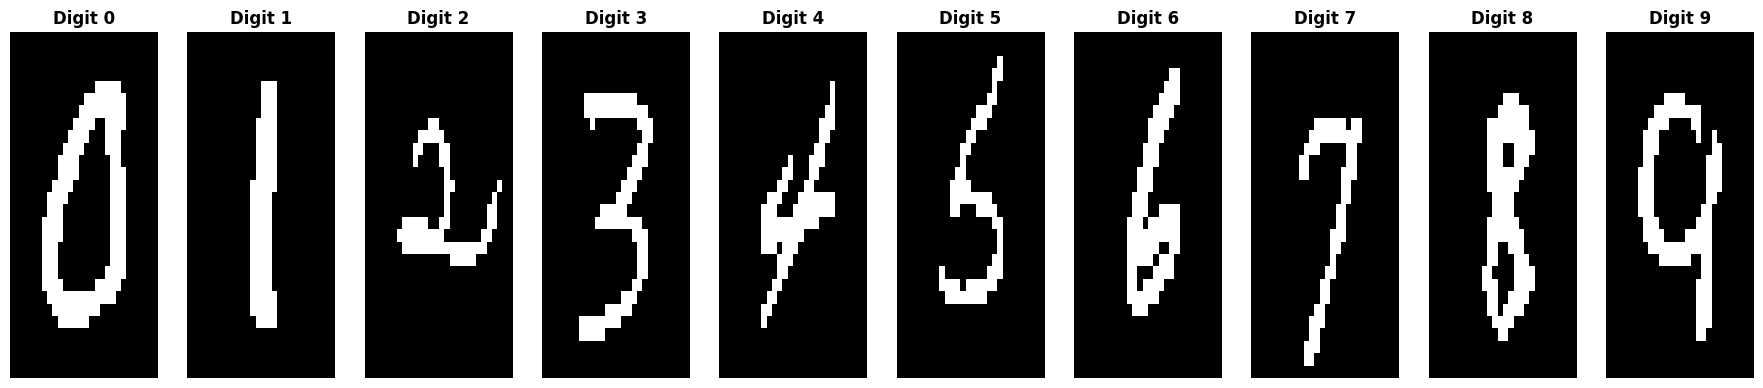

In [12]:
num_row, num_col = 1, 10
len_tr = len(x_train)
f, subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

for cls in np.unique(y_train):
    idx = np.arange(len_tr)[y_train == cls]
    idx = np.random.choice(idx)
    X_img = x_train[idx]
    subplots[cls].imshow(X_img, cmap='gray',
                       interpolation='nearest', aspect='auto')
    subplots[cls].set_title(f'Digit {cls}', fontweight="bold")
    subplots[cls].grid(visible=False)
    subplots[cls].axis('off')

f.set_size_inches(22.5, 4.5)

**Step 1: training the Naive Bayes classifier on the training set.**

In [13]:
# get the model
nbc = NaiveBayesClassifier()

# train
nbc.fit(x_train, y_train)

**Step 2: evaluating the performance of the classifier on a set of unseen data (test set).**

Accuracy: 0.8442


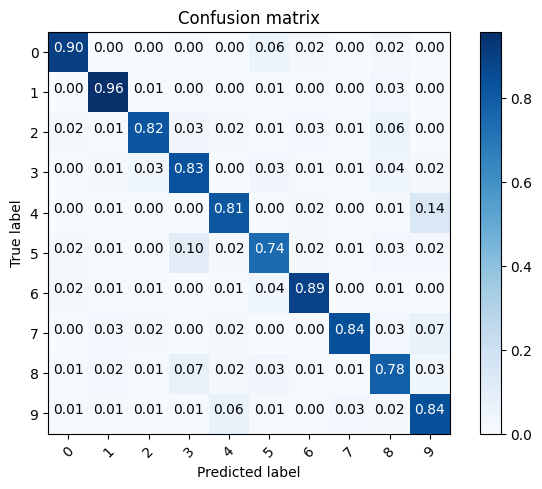

In [14]:
import itertools

def plot_confusion_matrix(targets, predictions, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    n_classes, = np.unique(targets).shape

    cm = np.zeros(shape=(n_classes, n_classes), dtype=np.float32)
    for t, p in zip(targets, predictions):
        cm[int(t), int(p)] += 1

    if normalize:
        cm /= cm.sum(axis=1)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test
predictions = nbc.predict(x_test.reshape((len(x_test), -1)))

# evaluate performances
accuracy = np.sum(np.uint8(predictions == y_test)) / len(y_test)
print('Accuracy: {}'.format(accuracy))

# show confusion matrix
plot_confusion_matrix(targets=y_test,
                      predictions=predictions,
                      classes=[label_dict[l] for l in label_dict])

Text(0.5, 1.0, 'Target: 4, Prediction: 4')

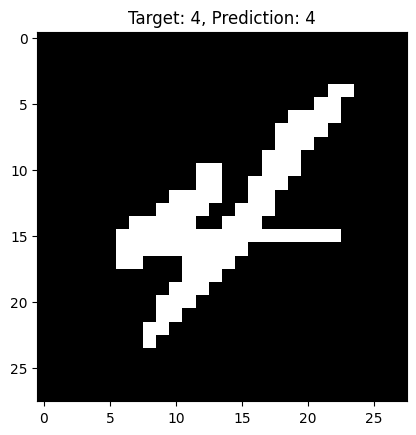

In [15]:
idx = np.random.randint(0, x_test.shape[0])

x = x_test[idx]
p = predictions[idx]
y = y_test[idx]

plt.imshow(x, cmap='gray')
plt.title('Target: {}, Prediction: {}'.format(label_dict[int(y)], label_dict[int(p)]))

In [16]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import io
from PIL import Image as PILimage

canvas_html = """
<canvas width=256 height=256></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.strokeStyle = "#FFFFFF"
ctx.fillStyle = "#000000";
ctx.fillRect(0, 0, 256, 256)
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', line_width=5, centercrop=True):
  display(HTML(canvas_html % (line_width, )))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  buf = io.BytesIO(binary)
  img = PILimage.open(buf)
  img = img.resize((28, 28), PILimage.BILINEAR)
  img = img.convert('LA')
  img = np.array(img)[:, :, 0]
  img = img > 75

  coords = np.argwhere(img)
  x_min, y_min = coords.min(axis=0)
  x_max, y_max = coords.max(axis=0)
  cropped = img[x_min:x_max+1, y_min:y_max+1]

  out_img = np.zeros((28,28))

  delta_x, delta_y = (28 - cropped.shape[0]) // 2, (28 - cropped.shape[1]) // 2
  out_img[delta_x:delta_x + cropped.shape[0], delta_y :delta_y + + cropped.shape[1]] = cropped

  return out_img.astype(np.float32)

ModuleNotFoundError: No module named 'google'

In [ ]:
img = draw(line_width=10)
print(img.shape, img.dtype, np.unique(img))
plt.imshow(img, cmap='Greys_r')

pred, negllk = nbc.predict(img.reshape(1, 28*28), True)
classes_ord = np.arange(len(np.unique(y_test)))[np.argsort(negllk)]
classes_ord = np.flip(classes_ord)
print(f'Predicted - {pred}')
print(f'Scores: {negllk}')
print(f'Classes ordered by scores: {classes_ord}')

NameError: name 'draw' is not defined